# Model for Tumor classification

## Motivation and goals

#### Problem and Relevance
Brain tumors represent a significant health concern due to their potential for severe outcomes, including neurological damage and death. Early and accurate detection of brain tumors is crucial for effective treatment and improving patient prognosis. Traditionally, radiologists manually examine MRI scans to diagnose brain tumors, which can be time-consuming, subjective, and prone to human error. There is a pressing need for automated, reliable, and efficient diagnostic tools to aid in the early detection and classification of brain tumors.

#### Project Motivation
1. **Improving Diagnostic Accuracy and Speed:**
   - **Reduction in Human Error:** Automated classification models can significantly reduce the variability and errors associated with manual interpretation by radiologists. This ensures more consistent and accurate diagnoses.
   - **Efficiency:** Automated systems can process large volumes of MRI scans rapidly, allowing for quicker diagnosis and treatment planning, which is critical in medical emergencies.

2. **Supporting Radiologists:**
   - **Augmenting Clinical Expertise:** Machine learning models can serve as a second opinion for radiologists, providing them with additional confidence in their diagnoses. This can be especially beneficial in complex cases where the presence of a tumor may not be immediately apparent.
   - **Workload Management:** With the increasing number of MRI scans conducted annually, radiologists face substantial workloads. Automated tools can help manage this workload, allowing radiologists to focus on more complex and critical cases.

3. **Technological Advancements:**
   - **Explainable AI:** By using explainable AI techniques, the project aims to not only provide accurate classifications but also ensure that the decision-making process of the model is transparent and interpretable.

#### Personal Motivation
I'm working in the medical field and am very interested in medical image classification models. This interest drives my desire to work with MRI images, try different state-of-the-art models, and experiment with fine-tuning these models. The potential of these models to improve diagnostic accuracy and efficiency in a clinical setting inspires me to delve deeper into this area.

## Set up project

### Import libraries

In [11]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix
from google.colab import drive
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor
import pickle
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras import mixed_precision
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import ResNet50, VGG16
from tensorflow.keras.applications import EfficientNetB0
from collections import Counter

### Download Images

You can download the data from the following sources:

#### Kaggle Datasets:
1. **First Dataset:**
   - [Brain Tumor Classification (MRI)](https://www.kaggle.com/datasets/sartajbhuvaj/brain-tumor-classification-mri)

2. **Additional Data:**
   - [Brain Tumor Detection](https://www.kaggle.com/datasets/ahmedhamada0/brain-tumor-detection?select=no)
   - [Brain Tumor MRI Image Classification](https://www.kaggle.com/datasets/iashiqul/brain-tumor-mri-image-classification/data)

#### Google Drive:
1. **First Data:**
   - [Download Link](https://drive.google.com/drive/folders/1L1N_F4S0OcnyhXKY4PK5vSyI6SvmMdB9?usp=sharing)

2. **Combined Data:**
   - [Download Link](https://drive.google.com/drive/folders/1LZliDGpo7wjKdoFt90hny4DwsR5XXBo0?usp=share_link)

#### Github Repository
https://github.com/kobivkaj/ML-Projekt.git

#### Instructions
If you are running this code on Google Colab, you can connect your Google Drive to this notebook. Alternatively, you can download the data from the provided Google Drive links or Kaggle and use it on your local machine.

**Important Note:**
Remember to update the image directory paths in the following code to avoid errors. For the initial analysis, only the first dataset was used. Later, two additional datasets were included. The script for merging these datasets is available in the GitHub repository.

### Connection to Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')
folder_path = '/content/drive/MyDrive/combined'
files = os.listdir(folder_path)

Mounted at /content/drive


## Data Exploration

In this part, we are going to explore the data from the first dataset. We are interested in the amount of data and the distribution of the classes. The exploration will help us understand the dataset better and guide the preprocessing and model training steps.

### Count of Images per Class

<ipython-input-27-95bfa42fc228>:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=classes, y=counts, palette=colors, dodge=False)


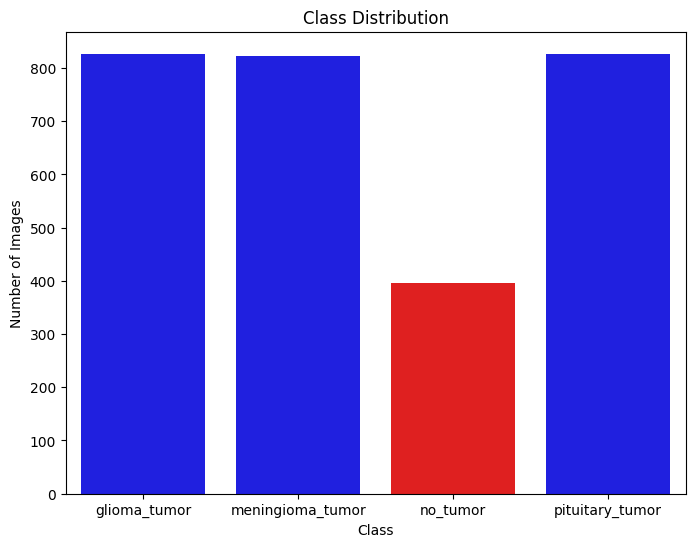

In [27]:
# Function to load image paths and labels
def load_image_paths_and_labels(image_dir, labels):
    image_paths = []
    processed_labels = []
    for label in labels:
        label_dir = os.path.join(image_dir, label)
        image_files = os.listdir(label_dir)
        for image_file in image_files:
            image_paths.append(os.path.join(label_dir, image_file))
            processed_labels.append(labels[label])
    return image_paths, np.array(processed_labels)

# Specify the path to the images and labels
image_dir = '/content/drive/MyDrive/tumor_brain_mri/Training'
labels_dict = {'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}
image_paths, processed_labels = load_image_paths_and_labels(image_dir, labels_dict)

# Plot class distribution
def plot_class_distribution(labels, labels_dict):
    label_counts = Counter(labels)
    classes = list(labels_dict.keys())
    counts = [label_counts[labels_dict[cls]] for cls in classes]
    colors = ['blue', 'blue', 'red', 'blue']

    plt.figure(figsize=(8, 6))
    sns.barplot(x=classes, y=counts, palette=colors, dodge=False)
    plt.xlabel('Class')
    plt.ylabel('Number of Images')
    plt.title('Class Distribution')
    plt.show()

plot_class_distribution(processed_labels, labels_dict)

### Merge tumor images into one category

<ipython-input-28-3a83ea9d9440>:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=classes, y=counts, palette=colors)


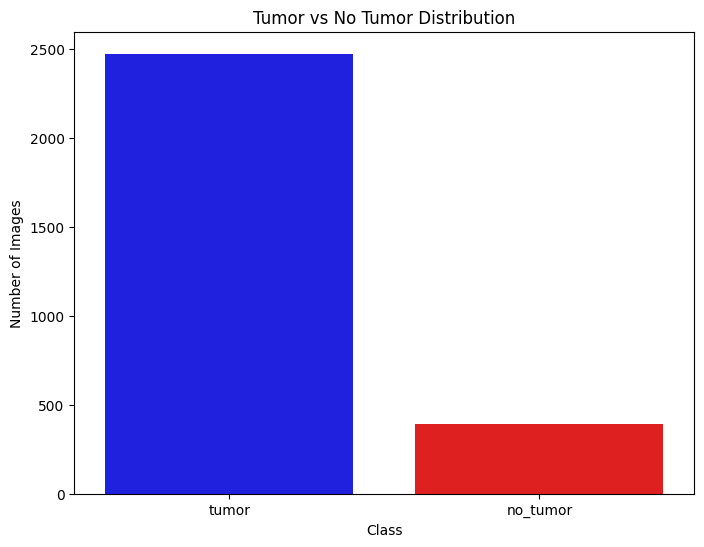

In [28]:
# Function to load image paths and labels
def load_image_paths_and_labels(image_dir, labels):
    image_paths = []
    processed_labels = []
    for label in labels:
        label_dir = os.path.join(image_dir, label)
        image_files = os.listdir(label_dir)
        for image_file in image_files:
            image_paths.append(os.path.join(label_dir, image_file))
            processed_labels.append(labels[label])
    return image_paths, np.array(processed_labels)

# Specify the path to the images and labels
image_dir = '/content/drive/MyDrive/tumor_brain_mri/Training'
labels_dict = {'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}
image_paths, processed_labels = load_image_paths_and_labels(image_dir, labels_dict)

# Plot class distribution
def plot_class_distribution(labels, labels_dict):
    label_counts = Counter(labels)
    tumor_count = sum(label_counts[labels_dict[cls]] for cls in labels_dict if cls != 'no_tumor')
    no_tumor_count = label_counts[labels_dict['no_tumor']]

    classes = ['tumor', 'no_tumor']
    counts = [tumor_count, no_tumor_count]
    colors = ['blue', 'red']

    plt.figure(figsize=(8, 6))
    sns.barplot(x=classes, y=counts, palette=colors)
    plt.xlabel('Class')
    plt.ylabel('Number of Images')
    plt.title('Tumor vs No Tumor Distribution')
    plt.show()

plot_class_distribution(processed_labels, labels_dict)

It is clearly visible that there is a strong class imbalance between the two classes, tumor and no tumor. Therefore, we need to implement a few steps to avoid overfitting the model.

### Display Sample Images

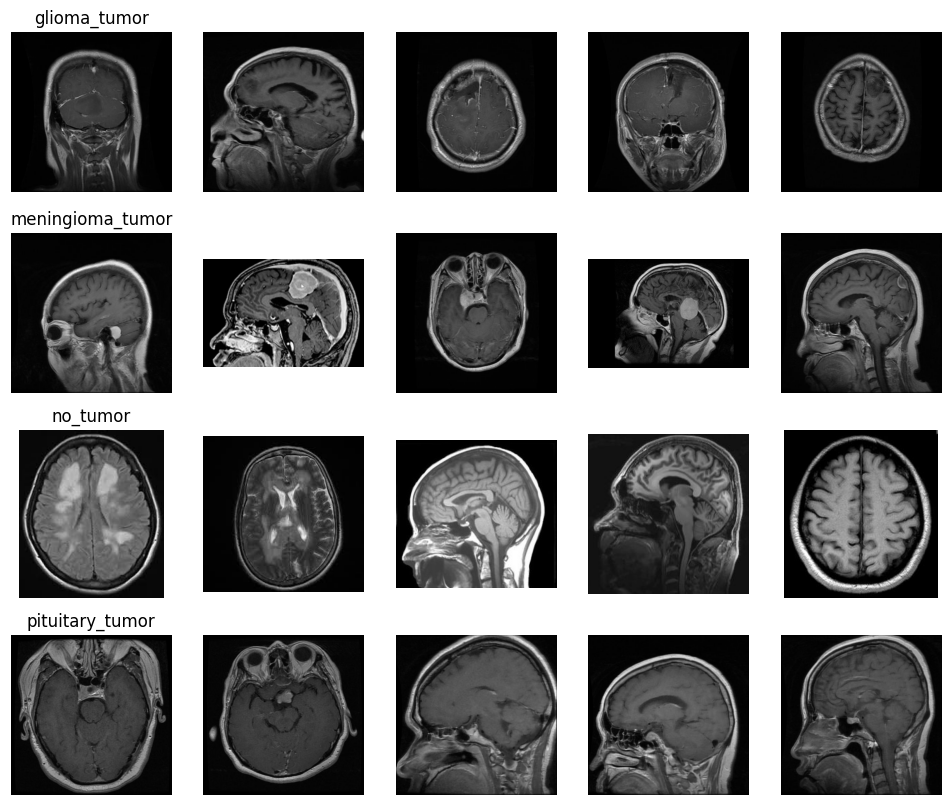

In [ ]:
def display_sample_images(image_paths, labels, label_names, n=5):
    plt.figure(figsize=(12, 10))
    unique_labels = np.unique(labels)
    for label in unique_labels:
        label_indices = np.where(labels == label)[0]
        sample_indices = np.random.choice(label_indices, n, replace=False)
        for i, idx in enumerate(sample_indices):
            plt.subplot(len(unique_labels), n, label * n + i + 1)
            image = cv2.imread(image_paths[idx])
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            plt.imshow(image)
            plt.axis('off')
            if i == 0:
                plt.title(label_names[label])
    plt.show()

label_names = {0: 'glioma_tumor', 1: 'meningioma_tumor', 2: 'no_tumor', 3: 'pituitary_tumor'}
display_sample_images(image_paths, processed_labels, label_names)


These are five sample images from each label.

## Single Dataset

This is a self-trained CNN model with 2 epochs using the first dataset. The goal was to see how well the model can classify the class-imbalanced images.

In [ ]:
def load_and_preprocess_images(image_dir, labels, img_size=(224, 224)):
    images = []
    processed_labels = []
    for label in labels:
        label_dir = os.path.join(image_dir, label)
        for image_file in os.listdir(label_dir):
            image_path = os.path.join(label_dir, image_file)
            image = cv2.imread(image_path)
            if image is not None:
                image = cv2.resize(image, img_size)
                images.append(image)
                processed_labels.append(labels[label])
    images = np.array(images) / 255.0
    processed_labels = to_categorical(np.array(processed_labels))
    return images, processed_labels

# Load data
image_dir = '/content/drive/MyDrive/tumor_brain_mri/Training'
labels = {'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}
images, processed_labels = load_and_preprocess_images(image_dir, labels)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(images, processed_labels, test_size=0.2, random_state=42)

def create_cnn_model(input_shape, num_classes):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

input_shape = (224, 224, 3)
num_classes = 4
model = create_cnn_model(input_shape, num_classes)
model.summary()

# Train the model
history = model.fit(X_train, y_train, epochs=2, validation_data=(X_val, y_val), batch_size=32)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 26, 26, 128)       0

## Combined Dataset

From here, we are going to use the combined dataset from the three data sources. There are two classes: tumor and no tumor, which will be used to train different self-trained and pre-trained models.

### CNN model

In [ ]:
def load_image_paths_and_labels(image_dir, labels):
    image_paths = []
    processed_labels = []

    for label in labels:
        label_dir = os.path.join(image_dir, label)
        image_files = os.listdir(label_dir)
        for image_file in image_files:
            image_paths.append(os.path.join(label_dir, image_file))
            processed_labels.append(labels[label])

    processed_labels = to_categorical(np.array(processed_labels))
    return image_paths, processed_labels

# Load data
image_dir = '/content/drive/MyDrive/combined/train'
labels = {'tumor': 0, 'no_tumor': 1}
image_paths, processed_labels = load_image_paths_and_labels(image_dir, labels)

# Split the data into training and validation sets
image_paths_train, image_paths_val, y_train, y_val = train_test_split(image_paths, processed_labels, test_size=0.2, random_state=42)

# Create an ImageDataGenerator
def preprocess_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.resize(image, (224, 224))
    return image / 255.0

def data_generator(image_paths, labels, batch_size):
    while True:
        for start in range(0, len(image_paths), batch_size):
            end = min(start + batch_size, len(image_paths))
            batch_image_paths = image_paths[start:end]
            batch_labels = labels[start:end]
            images = [preprocess_image(img_path) for img_path in batch_image_paths]
            yield np.array(images), np.array(batch_labels)

# Create model
def create_cnn_model(input_shape, num_classes):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

input_shape = (224, 224, 3)
num_classes = 2
model = create_cnn_model(input_shape, num_classes)
model.summary()

batch_size = 32

# Training the model using generators
train_generator = data_generator(image_paths_train, y_train, batch_size)
val_generator = data_generator(image_paths_val, y_val, batch_size)

steps_per_epoch = len(image_paths_train) // batch_size
validation_steps = len(image_paths_val) // batch_size

history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_generator,
    validation_steps=validation_steps,
    epochs=10
)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 26, 26, 128)       0

The first model had an accuracy of 0.7326 after two epochs. Now, after adding more data, the model's performance increased rapidly to an accuracy of 0.9071.

### Using class_weight

Found 4426 images belonging to 2 classes.
Found 1106 images belonging to 2 classes.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                      

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


276/276 [==============================] - 474s 2s/step - loss: 0.4686 - accuracy: 0.8088 - val_loss: 0.4778 - val_accuracy: 0.8451
Epoch 2/2
69/69 [==============================] - 7s 105ms/step
              precision    recall  f1-score   support

       tumor       0.71      0.78      0.74       776
    no_tumor       0.31      0.23      0.26       328

    accuracy                           0.62      1104
   macro avg       0.51      0.51      0.50      1104
weighted avg       0.59      0.62      0.60      1104



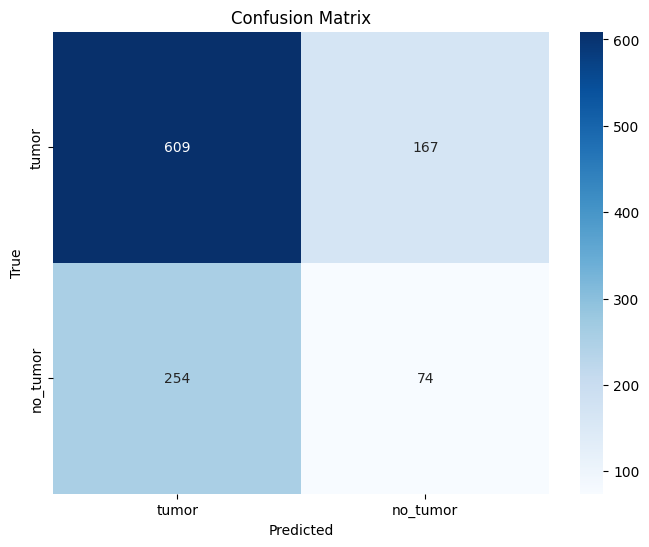

In [3]:
# Function to create a CNN model
def create_cnn_model(input_shape, num_classes):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Specify the path to the images and labels
image_dir = '/content/drive/MyDrive/combined/train'
labels = {'tumor': 0, 'no_tumor': 1}

# Create ImageDataGenerator instances for training and validation
datagen = ImageDataGenerator(rescale=1.0/255.0, validation_split=0.2)

train_generator = datagen.flow_from_directory(
    image_dir,
    target_size=(224, 224),
    batch_size=16,  # Reduced batch size to save memory
    class_mode='categorical',
    subset='training',
    classes=list(labels.keys())
)

val_generator = datagen.flow_from_directory(
    image_dir,
    target_size=(224, 224),
    batch_size=16,  # Reduced batch size to save memory
    class_mode='categorical',
    subset='validation',
    classes=list(labels.keys())
)

# Calculate class weights
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(train_generator.classes), y=train_generator.classes)
class_weights_dict = dict(enumerate(class_weights))

input_shape = (224, 224, 3)
num_classes = len(labels)  # Adjust based on the labels dictionary
model = create_cnn_model(input_shape, num_classes)
model.summary()

# Model checkpoint
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, mode='min')

steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = val_generator.samples // val_generator.batch_size

# Training the model using generators
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_generator,
    validation_steps=validation_steps,
    epochs=2,
    class_weight=class_weights_dict,
    callbacks=[checkpoint]
)

# Evaluate the model
val_generator.reset()
y_val_pred = model.predict(val_generator, steps=validation_steps)
y_val_pred_classes = np.argmax(y_val_pred, axis=1)

# Extract the true classes from the validation generator
y_val_true_classes = val_generator.classes[:len(y_val_pred_classes)]

print(classification_report(y_val_true_classes, y_val_pred_classes, target_names=list(labels.keys())))

# Confusion matrix
cm = confusion_matrix(y_val_true_classes, y_val_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list(labels.keys()), yticklabels=list(labels.keys()))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


#### Print class weight after modeling

In [4]:
print(class_weights_dict)

{0: 0.7124919510624598, 1: 1.6765151515151515}


The class weight analysis shows that there is still a class imbalance, with the no tumor class being underrepresented in the dataset. This is why we are going to add data augmentation to the project.

## Data Augmentation

I've run this code on my own device and have not tested it on Colab to avoid long processing times. You can run this code on your device if you would like to check its runnability.

In [ ]:
# Define refined augmentation pipeline without RandomElasticDeformation
transform = tio.Compose([
    tio.RandomBlur(p=0.2),
    tio.RandomNoise(p=0.2),
    tio.RandomAffine(scales=(0.98, 1.02), degrees=2, isotropic=True, translation=(0, 0, 0), p=0.2),
    tio.RandomBiasField(coefficients=0.1, p=0.2),
    tio.RandomMotion(degrees=2, translation=2, num_transforms=1, p=0.2)
])

# Function to augment and save images
def augment_images(image_dir, save_dir, target_count=2000):
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    image_names = os.listdir(image_dir)
    num_images = len(image_names)
    num_augmentations = target_count // num_images
    additional_images = target_count % num_images

    for image_name in image_names:
        image_path = os.path.join(image_dir, image_name)
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        image = np.expand_dims(image, axis=(0, 1))
        subject = tio.Subject(
            mri=tio.ScalarImage(tensor=image)
        )

        for i in range(num_augmentations):
            augmented_subject = transform(subject)
            augmented_image = augmented_subject['mri'].numpy().squeeze()
            augmented_image_name = f"{os.path.splitext(image_name)[0]}_aug_{i}.png"
            augmented_image_path = os.path.join(save_dir, augmented_image_name)
            cv2.imwrite(augmented_image_path, augmented_image)

    # Augment additional images
    for i in range(additional_images):
        image_name = image_names[i % num_images]
        image_path = os.path.join(image_dir, image_name)
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        image = np.expand_dims(image, axis=(0, 1))
        subject = tio.Subject(
            mri=tio.ScalarImage(tensor=image)
        )

        augmented_subject = transform(subject)
        augmented_image = augmented_subject['mri'].numpy().squeeze()
        augmented_image_name = f"{os.path.splitext(image_name)[0]}_extra_aug_{i}.png"
        augmented_image_path = os.path.join(save_dir, augmented_image_name)
        cv2.imwrite(augmented_image_path, augmented_image)

# Load and save image
no_tumor_image_dir = 'combined/train/no_tumor'
no_tumor_image_dir = '/content/drive/MyDrive/combined/train/no_tumor'
augmented_no_tumor_image_dir = '/content/drive/MyDrive/combined/train/no_tumor'
augment_images(no_tumor_image_dir, augmented_no_tumor_image_dir, target_count=2000)

### Print class weight after data augmentation

In [7]:
def count_images_in_merged_categories(image_dir, labels):
    tumor_dir = os.path.join('/content/drive/MyDrive', image_dir, 'tumor')
    no_tumor_dir = os.path.join('/content/drive/MyDrive', image_dir, 'no_tumor')
    aug_no_tumor_dir = os.path.join('/content/drive/MyDrive', image_dir, 'aug_no_tumor')

    # Count images in tumor directory
    image_counts = {'tumor': len([file for file in os.listdir(tumor_dir) if os.path.isfile(os.path.join(tumor_dir, file))])}

    # Count images in no_tumor and aug_no_tumor directories combined
    no_tumor_count = len([file for file in os.listdir(no_tumor_dir) if os.path.isfile(os.path.join(no_tumor_dir, file))])
    aug_no_tumor_count = len([file for file in os.listdir(aug_no_tumor_dir) if os.path.isfile(os.path.join(aug_no_tumor_dir, file))])

    image_counts['no_tumor'] = no_tumor_count + aug_no_tumor_count

    return image_counts

# Example usage
image_dir = 'combined/train'
labels = {'tumor': 0, 'no_tumor': 1, 'aug_no_tumor': 1}
image_counts = count_images_in_merged_categories(image_dir, labels)

# Print the counts of images in each category
print(f"Number of 'tumor' images: {image_counts['tumor']}")
print(f"Number of 'no_tumor' images: {image_counts['no_tumor']}")


Number of 'tumor' images: 3882
Number of 'no_tumor' images: 3650


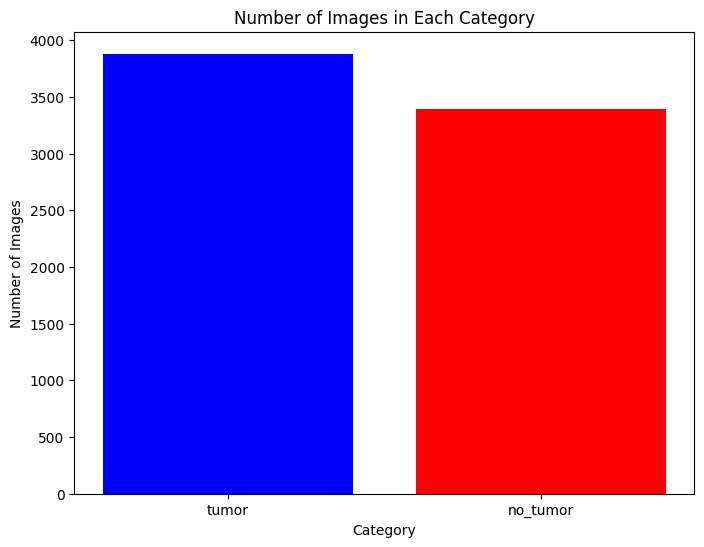

In [33]:
# Plot the counts of images in each category
def plot_image_counts(image_counts):
    categories = list(image_counts.keys())
    counts = list(image_counts.values())
    colors = ['blue', 'red']  # Tumor: blue, No tumor: red

    plt.figure(figsize=(8, 6))
    plt.bar(categories, counts, color=colors)
    plt.xlabel('Category')
    plt.ylabel('Number of Images')
    plt.title('Number of Images in Each Category')
    plt.show()

plot_image_counts(image_counts)

With the data augmentation, we were able to address the class imbalance problem and now have enough images to work with without worrying about overfitting issues.

### Display augmented sample images

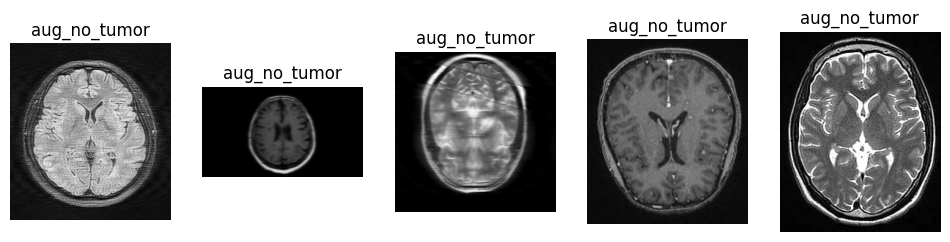

In [ ]:
def display_sample_images_from_folder(folder_path, n=5):
    image_files = os.listdir(folder_path)
    sample_indices = np.random.choice(len(image_files), n, replace=False)

    plt.figure(figsize=(12, 10))
    for i, idx in enumerate(sample_indices):
        image_path = os.path.join(folder_path, image_files[idx])
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.subplot(1, n, i + 1)
        plt.imshow(image)
        plt.axis('off')
        plt.title("aug_no_tumor")
    plt.show()

# Specify the path to the 'aug_no_tumor' folder
aug_no_tumor_folder_path = '/content/drive/MyDrive/combined/train/aug_no_tumor'

# Display sample images from the 'aug_no_tumor' folder
display_sample_images_from_folder(aug_no_tumor_folder_path, n=5)


### Display merged augmented images

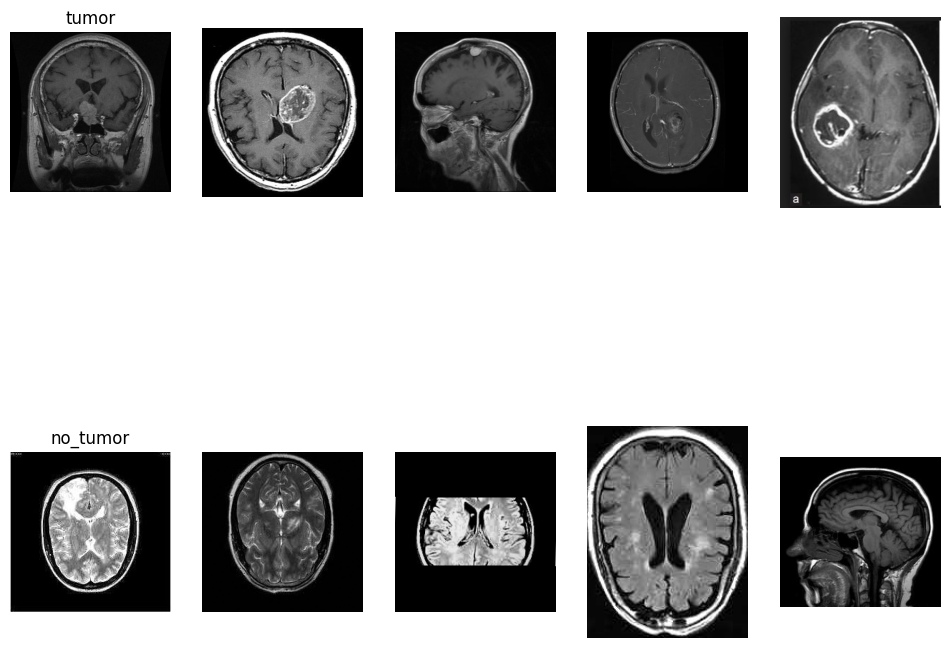

In [ ]:
def display_sample_images(image_paths, labels, label_names, n=5):
    plt.figure(figsize=(12, 10))
    unique_labels = np.unique(labels)
    for label in unique_labels:
        label_indices = np.where(labels == label)[0]
        sample_indices = np.random.choice(label_indices, n, replace=False)
        for i, idx in enumerate(sample_indices):
            plt.subplot(len(unique_labels), n, label * n + i + 1)
            image = cv2.imread(image_paths[idx])
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            plt.imshow(image)
            plt.axis('off')
            if i == 0:
                plt.title(label_names[label])
    plt.show()

# Updated label names based on your dataset
label_names = {0: 'tumor', 1: 'no_tumor'}

# Specify the path to the images and labels
image_dir = '/content/drive/MyDrive/combined/train'
labels_dict = {'tumor': 0, 'no_tumor': 1, 'aug_no_tumor': 1}

# Function to load image paths and labels
def load_image_paths_and_labels(image_dir, labels):
    image_paths = []
    processed_labels = []
    for label in labels:
        label_dir = os.path.join(image_dir, label)
        image_files = os.listdir(label_dir)
        for image_file in image_files:
            image_paths.append(os.path.join(label_dir, image_file))
            processed_labels.append(labels[label])
    return image_paths, np.array(processed_labels)

image_paths, processed_labels = load_image_paths_and_labels(image_dir, labels_dict)

# Display sample images
display_sample_images(image_paths, processed_labels, label_names)


### VGG model

Let's use a pre-trained VGG (Visual Geometry Group) model, known for its deep convolutional architecture and success in image classification tasks, on the new dataset containing the combined data with the augmented data. The VGG16 model has been trained on the ImageNet dataset and can leverage its learned features to improve performance on our new dataset.

58889256/58889256 [==============================] - 4s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

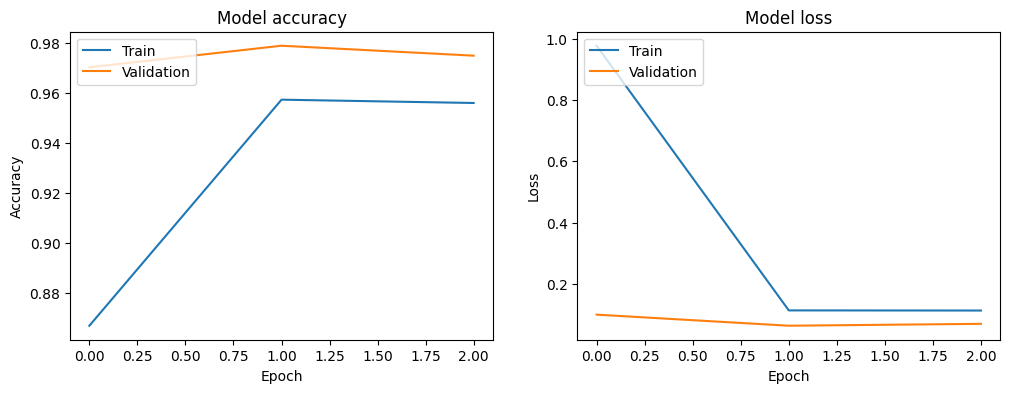

48/48 [==============================] - 1s 12ms/step
              precision    recall  f1-score   support

       tumor       1.00      0.95      0.97       773
    no_tumor       0.95      1.00      0.97       734

    accuracy                           0.97      1507
   macro avg       0.98      0.98      0.97      1507
weighted avg       0.98      0.97      0.97      1507

[[738  35]
 [  3 731]]


In [ ]:
# Enable mixed precision training
mixed_precision.set_global_policy('mixed_float16')

# Function to load and preprocess images
def load_and_preprocess_images(image_dir, labels, img_size=(224, 224)):
    images = []
    processed_labels = []
    for label in labels:
        label_dir = os.path.join(image_dir, label)
        for image_file in os.listdir(label_dir):
            image_path = os.path.join(label_dir, image_file)
            image = cv2.imread(image_path)
            if image is not None:
                image = cv2.resize(image, img_size)
                images.append(image)
                processed_labels.append(labels[label])
    images = np.array(images) / 255.0
    processed_labels = to_categorical(np.array(processed_labels))
    return images, processed_labels

# Load data
image_dir = '/content/drive/MyDrive/combined/train'
labels = {'tumor': 0, 'no_tumor': 1, 'aug_no_tumor': 1}
images, processed_labels = load_and_preprocess_images(image_dir, labels)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(images, processed_labels, test_size=0.2, random_state=42)

# Function to create the VGG16-based model
def create_vgg_model(input_shape, num_classes):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    x = base_model.output
    x = Flatten()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)

    for layer in base_model.layers:
        layer.trainable = False

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Model parameters
input_shape = (224, 224, 3)
num_classes = 2

# Create and summarize the VGG16-based model
model = create_vgg_model(input_shape, num_classes)
model.summary()

# Train the model
history = model.fit(X_train, y_train, epochs=3, validation_data=(X_val, y_val), batch_size=32)

# Plotting the training history
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

# Evaluate the model
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_val, axis=1)

print(classification_report(y_true, y_pred_classes, target_names=['tumor', 'no_tumor']))
conf_matrix = confusion_matrix(y_true, y_pred_classes)
print(conf_matrix)

With the new dataset, we were able to achieve higher accuracy even after just two epochs. This is a good sign that the data augmentation helped to improve the model's performance.



### CNN

Now let's use the CNN model again with our newly created dataset.

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 26, 26, 128)       0

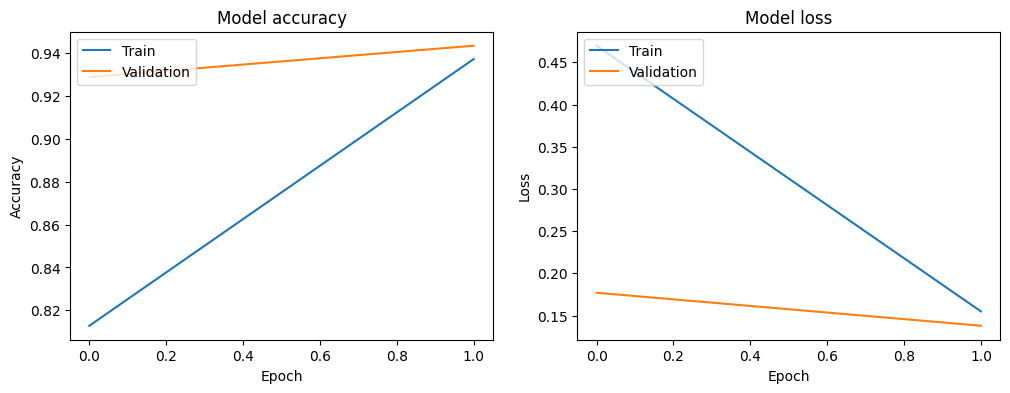

47/47 [==============================] - 10s 218ms/step


In [ ]:
# Function to load image paths and labels
def load_image_paths_and_labels(image_dir, labels):
    image_paths = []
    processed_labels = []
    for label in labels:
        label_dir = os.path.join(image_dir, label)
        image_files = os.listdir(label_dir)
        for image_file in image_files:
            image_paths.append(os.path.join(label_dir, image_file))
            processed_labels.append(labels[label])
    return image_paths, np.array(processed_labels)

# Data generator
def data_generator(image_paths, labels, batch_size, img_size=(224, 224), num_classes=2):
    while True:
        for start in range(0, len(image_paths), batch_size):
            end = min(start + batch_size, len(image_paths))
            batch_image_paths = image_paths[start:end]
            batch_labels = labels[start:end]
            images = [preprocess_image(img_path, img_size) for img_path in batch_image_paths]
            yield np.array(images), to_categorical(np.array(batch_labels), num_classes=num_classes)

# Function to preprocess images
def preprocess_image(image_path, img_size=(224, 224)):
    image = cv2.imread(image_path)
    if image is not None:
        image = cv2.resize(image, img_size)
        image = image / 255.0
    return image

# Load data
image_dir = '/content/drive/MyDrive/combined/train'
labels_dict = {'tumor': 0, 'no_tumor': 1, 'aug_no_tumor': 1}
image_paths, processed_labels = load_image_paths_and_labels(image_dir, labels_dict)

# Split the data into training and validation sets
image_paths_train, image_paths_val, y_train, y_val = train_test_split(image_paths, processed_labels, test_size=0.2, random_state=42)

# Calculate class weights (optional, for handling class imbalance)
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))

# Create model
def create_cnn_model(input_shape, num_classes):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

input_shape = (224, 224, 3)
num_classes = 2
model = create_cnn_model(input_shape, num_classes)
model.summary()

batch_size = 32

# Training the model using generators
train_generator = data_generator(image_paths_train, y_train, batch_size, num_classes=num_classes)
val_generator = data_generator(image_paths_val, y_val, batch_size, num_classes=num_classes)

steps_per_epoch = len(image_paths_train) // batch_size
validation_steps = len(image_paths_val) // batch_size

history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_generator,
    validation_steps=validation_steps,
    epochs=2,
    class_weight=class_weights_dict
)

# Plotting the training history
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

### Preprocess CNN Model

The main difference between the CNN model above and the following one is the use of **ImageDataGenerator** in the previous code for handling data augmentation and splitting, while the new code uses a **custom data_generator** for generating batches of data during training. The new model can be more memory-efficient, especially for large datasets, as it processes images in batches rather than loading the entire dataset into memory at once.

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 26, 26, 128)       0

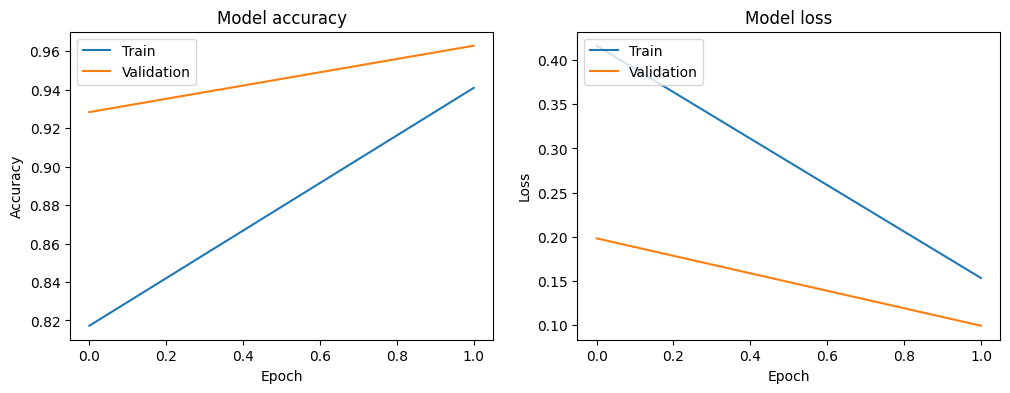

48/48 [==============================] - 0s 7ms/step
              precision    recall  f1-score   support

       tumor       0.98      0.94      0.96       773
    no_tumor       0.94      0.98      0.96       734

    accuracy                           0.96      1507
   macro avg       0.96      0.96      0.96      1507
weighted avg       0.96      0.96      0.96      1507

[[729  44]
 [ 12 722]]


In [ ]:
# Function to load and preprocess images
def load_and_preprocess_images(image_dir, labels, img_size=(224, 224)):
    images = []
    processed_labels = []
    for label in labels:
        label_dir = os.path.join(image_dir, label)
        for image_file in os.listdir(label_dir):
            image_path = os.path.join(label_dir, image_file)
            image = cv2.imread(image_path)
            if image is not None:
                image = cv2.resize(image, img_size)
                images.append(image)
                processed_labels.append(labels[label])
    images = np.array(images) / 255.0
    processed_labels = to_categorical(np.array(processed_labels))
    return images, processed_labels

# Load data
image_dir = '/content/drive/MyDrive/combined/train'
labels = {'tumor': 0, 'no_tumor': 1, 'aug_no_tumor': 1}
images, processed_labels = load_and_preprocess_images(image_dir, labels)
integer_labels = np.argmax(processed_labels, axis=1)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(images, processed_labels, test_size=0.2, random_state=42)

# Calculate class weights
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(integer_labels), y=integer_labels)
class_weights_dict = dict(enumerate(class_weights))

# Function to create the CNN model
def create_cnn_model(input_shape, num_classes):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Model parameters
input_shape = (224, 224, 3)
num_classes = 2

# Create and summarize the model
model = create_cnn_model(input_shape, num_classes)
model.summary()

# Train the model with class weights
history = model.fit(X_train, y_train, epochs=2, validation_data=(X_val, y_val), batch_size=32, class_weight=class_weights_dict)

# Plotting the training history
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

# Evaluate the model
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_val, axis=1)

print(classification_report(y_true, y_pred_classes, target_names=['tumor', 'no_tumor']))
conf_matrix = confusion_matrix(y_true, y_pred_classes)
print(conf_matrix)


This is by far the best model that has been created. With an accuracy of 0.96, the performance is significantly better than the first model, which had an accuracy of 0.7326. The new model is approximately 31 % better in terms of accuracy.

#### Print new class weight

In [ ]:
print(class_weights_dict)

{0: 0.970118495620814, 1: 1.0317808219178082}


The class weight shows a far better value than earlier, indicating improved handling of class imbalance.

### Multithreading Preprocessing

Now we will use a multithreading preprocessing model. This technique involves using multiple threads to perform data preprocessing tasks in parallel, significantly speeding up processing time by utilizing multiple CPU cores simultaneously. This approach is especially useful for handling large datasets or computationally intensive preprocessing steps, as it allows for more efficient use of system resources and reduces the time required to prepare data for model training, thereby improving overall model training performance.

{0: 0.970118495620814, 1: 1.0317808219178082}
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooli

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


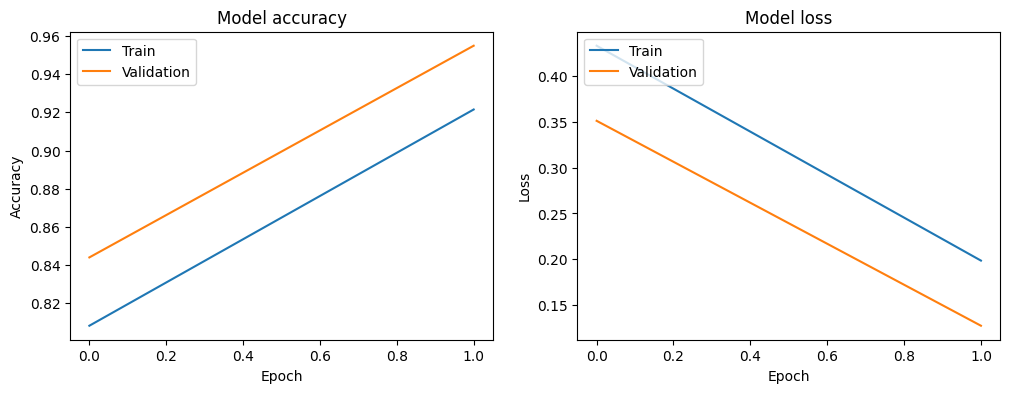

48/48 [==============================] - 1s 14ms/step
              precision    recall  f1-score   support

       tumor       0.97      0.94      0.96       773
    no_tumor       0.94      0.97      0.95       734

    accuracy                           0.95      1507
   macro avg       0.96      0.96      0.95      1507
weighted avg       0.96      0.95      0.95      1507

[[724  49]
 [ 19 715]]


In [ ]:
# Function to load and preprocess a single image
def load_and_preprocess_single_image(image_path, img_size):
    image = cv2.imread(image_path)
    if image is not None:
        image = cv2.resize(image, img_size)
        return image
    return None

# Function to load and preprocess images with multithreading
def load_and_preprocess_images(image_dir, labels, img_size=(224, 224)):
    images = []
    processed_labels = []
    with ThreadPoolExecutor() as executor:
        futures = []
        for label in labels:
            label_dir = os.path.join(image_dir, label)
            for image_file in os.listdir(label_dir):
                image_path = os.path.join(label_dir, image_file)
                futures.append(executor.submit(load_and_preprocess_single_image, image_path, img_size))

        for future, label in zip(futures, [labels[label] for label in labels for _ in os.listdir(os.path.join(image_dir, label))]):
            image = future.result()
            if image is not None:
                images.append(image)
                processed_labels.append(label)

    images = np.array(images) / 255.0
    processed_labels = to_categorical(np.array(processed_labels))
    return images, processed_labels

# Load data
image_dir = '/content/drive/MyDrive/combined/train'
labels = {'tumor': 0, 'no_tumor': 1, 'aug_no_tumor': 1}
images, processed_labels = load_and_preprocess_images(image_dir, labels)

# Save preprocessed data
with open('preprocessed_images.pkl', 'wb') as f:
    pickle.dump(images, f)
with open('preprocessed_labels.pkl', 'wb') as f:
    pickle.dump(processed_labels, f)

# Load preprocessed data
with open('preprocessed_images.pkl', 'rb') as f:
    images = pickle.load(f)
with open('preprocessed_labels.pkl', 'rb') as f:
    processed_labels = pickle.load(f)

# Convert processed_labels back to integer
integer_labels = np.argmax(processed_labels, axis=1)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(images, processed_labels, test_size=0.2, random_state=42)

# Calculate class weights using the original integer labels
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(integer_labels), y=integer_labels)

# Convert class_weights to a dictionary
class_weights_dict = dict(enumerate(class_weights))

print(class_weights_dict)

# Function to create the CNN model
def create_cnn_model(input_shape, num_classes):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Model parameters
input_shape = (224, 224, 3)
num_classes = 2

# Create and summarize the model
model = create_cnn_model(input_shape, num_classes)
model.summary()

# Train the model with class weights
history = model.fit(X_train, y_train, epochs=2, validation_data=(X_val, y_val), batch_size=32, class_weight=class_weights_dict)

# Save the model
model.save('brain_tumor_cnn_model.h5')

# Plotting the training history
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

# Evaluate the model
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_val, axis=1)

print(classification_report(y_true, y_pred_classes, target_names=['tumor', 'no_tumor']))
conf_matrix = confusion_matrix(y_true, y_pred_classes)
print(conf_matrix)


#### Test with new data

Now let's test the model with new test data that were not used for training.

Number of valid test images: 195
Number of test labels: 195
7/7 [==============================] - 0s 14ms/step
Test Set Classification Report:
              precision    recall  f1-score   support

       tumor       0.73      0.83      0.78       114
    no_tumor       0.70      0.56      0.62        81

    accuracy                           0.72       195
   macro avg       0.71      0.69      0.70       195
weighted avg       0.72      0.72      0.71       195



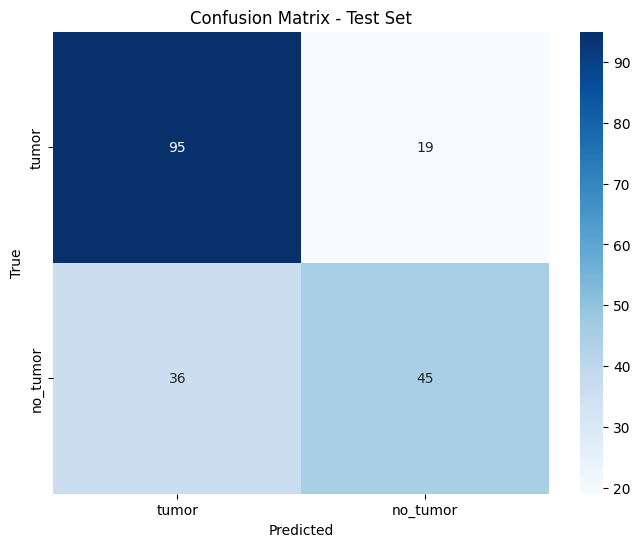

In [ ]:
# Function to load test images
def load_test_images(test_dir):
    test_image_paths = []
    test_labels = []
    for label, folder in enumerate(['tumor', 'no_tumor']):
        folder_path = os.path.join(test_dir, folder)
        for img_file in os.listdir(folder_path):
            test_image_paths.append(os.path.join(folder_path, img_file))
            test_labels.append(label)
    return test_image_paths, np.array(test_labels)

# Function to preprocess test images
def preprocess_test_image(image_path, img_size=(224, 224)):
    image = cv2.imread(image_path)
    if image is None:
        print(f"Failed to load image: {image_path}")
        return None
    image = cv2.resize(image, img_size)
    image = image / 255.0
    return image

# Load data
test_dir = '/content/drive/MyDrive/combined/test'  # Change this to your test image directory
test_image_paths, y_test_true = load_test_images(test_dir)

# Preprocess all test images
X_test = []
valid_test_image_paths = []

for img_path in test_image_paths:
    processed_image = preprocess_test_image(img_path)
    if processed_image is not None:
        X_test.append(processed_image)
        valid_test_image_paths.append(img_path)

X_test = np.array(X_test)

print(f"Number of valid test images: {len(X_test)}")
print(f"Number of test labels: {len(y_test_true)}")

assert len(X_test) == len(y_test_true), "The number of test images and test labels must match."

# Load the previous model
best_model = load_model('brain_tumor_cnn_model.h5')

# Predict on test data
y_test_pred = best_model.predict(X_test)
y_test_pred_classes = np.argmax(y_test_pred, axis=1)

# Classification report
print("Test Set Classification Report:")
print(classification_report(y_test_true, y_test_pred_classes, target_names=['tumor', 'no_tumor']))

# Confusion matrix
cm_test = confusion_matrix(y_test_true, y_test_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', xticklabels=['tumor', 'no_tumor'], yticklabels=['tumor', 'no_tumor'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Test Set')
plt.show()

The performance on the new test dataset was not very pleasing. The model achieved an overall accuracy of **72%**. For the "tumor" class, the precision was 0.73, recall was 0.83 and the F1-score was 0.78 with 114 instances. For the "no tumor" class, the precision was 0.70, recall was 0.56 and the F1-score was 0.62 with 81 instances. The macro average F1-score was 0.70, indicating that the model struggles more with the "no tumor" class.

### Baseline Model

Now let's try to use a baseline model. A baseline model is a simple, initial model used as a reference point to compare the performance of more complex models.

In [ ]:
def load_and_preprocess_images(image_dir, labels, img_size=(224, 224)):
    images = []
    processed_labels = []
    for label in labels:
        label_dir = os.path.join(image_dir, label)
        for image_file in os.listdir(label_dir):
            image_path = os.path.join(label_dir, image_file)
            image = cv2.imread(image_path)
            if image is not None:
                image = cv2.resize(image, img_size)
                images.append(image)
                processed_labels.append(labels[label])
    images = np.array(images) / 255.0
    processed_labels = to_categorical(np.array(processed_labels))
    return images, processed_labels

# Load data
image_dir = '/content/drive/MyDrive/combined/train'
labels = {'tumor': 0, 'no_tumor': 1, 'aug_no_tumor': 1}
images, processed_labels = load_and_preprocess_images(image_dir, labels)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(images, processed_labels, test_size=0.2, random_state=42)

def create_baseline_cnn_model(input_shape, num_classes):
    model = Sequential([
        Conv2D(16, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

input_shape = (224, 224, 3)
num_classes = 2
baseline_model = create_baseline_cnn_model(input_shape, num_classes)
baseline_model.summary()

# Train the baseline model
baseline_history = baseline_model.fit(X_train, y_train, epochs=2, validation_data=(X_val, y_val), batch_size=32)



Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 222, 222, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 111, 111, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 109, 109, 32)      4640      
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 54, 54, 32)        0         
 g2D)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 93312)             0         
                                                                 
 dense_4 (Dense)             (None, 128)              

During training, the model was trained for 2 epochs. In the first epoch, it achieved a training accuracy of 82.27% and a validation accuracy of 94.29%, with a loss of 0.5443 on the training set and 0.1596 on the validation set. In the second epoch, the model's training accuracy improved to 95.09%, with a validation accuracy of 96.08% and a reduced loss of 0.1350 on the training set and 0.1165 on the validation set. This indicates significant improvement and good performance on the validation data.

### ResNET 50 Model

As for the next model, we are going to use ResNet-50, a deep convolutional neural network with 50 layers, known for its ability to handle very deep architectures and commonly used in various image classification tasks due to its residual learning framework.

I've split the code into three steps to avoid crashes while training the model.

In [ ]:
# Function to load image paths and labels
def load_image_paths_and_labels(image_dir, labels):
    image_paths = []
    processed_labels = []
    for label in labels:
        label_dir = os.path.join(image_dir, label)
        image_files = os.listdir(label_dir)
        for image_file in image_files:
            image_paths.append(os.path.join(label_dir, image_file))
            processed_labels.append(labels[label])
    return image_paths, np.array(processed_labels)

# Function to preprocess images
def preprocess_image(image_path, img_size=(224, 224)):
    image = cv2.imread(image_path)
    if image is not None:
        image = cv2.resize(image, img_size)
        image = image / 255.0
    return image

# Load data
image_dir = '/content/drive/MyDrive/combined/train'
labels_dict = {'tumor': 0, 'no_tumor': 1, 'aug_no_tumor': 1}
image_paths, processed_labels = load_image_paths_and_labels(image_dir, labels_dict)

# Split the data into training and validation sets
image_paths_train, image_paths_val, y_train, y_val = train_test_split(image_paths, processed_labels, test_size=0.2, random_state=42)

# Calculate class weights
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))

# Data generator
def data_generator(image_paths, labels, batch_size, img_size=(224, 224)):
    while True:
        for start in range(0, len(image_paths), batch_size):
            end = min(start + batch_size, len(image_paths))
            batch_image_paths = image_paths[start:end]
            batch_labels = labels[start:end]
            images = [preprocess_image(img_path, img_size) for img_path in batch_image_paths]
            yield np.array(images), to_categorical(np.array(batch_labels), num_classes=2)

batch_size = 32
train_generator = data_generator(image_paths_train, y_train, batch_size)
val_generator = data_generator(image_paths_val, y_val, batch_size)


In [ ]:
def create_resnet_model(input_shape, num_classes):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)

    for layer in base_model.layers:
        layer.trainable = False

    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

input_shape = (224, 224, 3)
num_classes = 2
model = create_resnet_model(input_shape, num_classes)
model.summary()


94765736/94765736 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                         

Epoch 1/4
188/188 [==============================] - 53s 286ms/step - loss: 0.4972 - accuracy: 0.7557 - val_loss: 0.4381 - val_accuracy: 0.8224
Epoch 2/4
188/188 [==============================] - 50s 269ms/step - loss: 0.4707 - accuracy: 0.7781 - val_loss: 0.4220 - val_accuracy: 0.8312
Epoch 3/4
188/188 [==============================] - 49s 262ms/step - loss: 0.4539 - accuracy: 0.7874 - val_loss: 0.4273 - val_accuracy: 0.8075
Epoch 4/4
188/188 [==============================] - 49s 260ms/step - loss: 0.4513 - accuracy: 0.7959 - val_loss: 0.3967 - val_accuracy: 0.8393


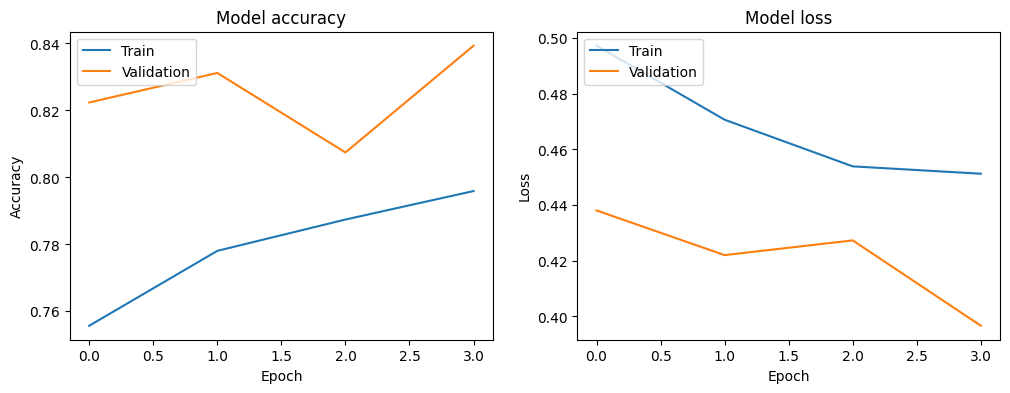

In [ ]:
steps_per_epoch = len(image_paths_train) // batch_size
validation_steps = len(image_paths_val) // batch_size

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_resnet_model.h5', monitor='val_loss', save_best_only=True)

history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_generator,
    validation_steps=validation_steps,
    epochs=4,
    class_weight=class_weights_dict,
    callbacks=[early_stopping, checkpoint]
)

# Plotting the training history
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

The ResNet-50 model was trained for 4 epochs, but the accuracy was very low compared to other models. Let's test this model with new test data.

#### Test with new data

Number of valid test images: 195
Number of test labels: 195
7/7 [==============================] - 1s 49ms/step
Test Set Classification Report:
              precision    recall  f1-score   support

       tumor       0.63      0.75      0.69       114
    no_tumor       0.52      0.40      0.45        81

    accuracy                           0.60       195
   macro avg       0.58      0.57      0.57       195
weighted avg       0.59      0.60      0.59       195



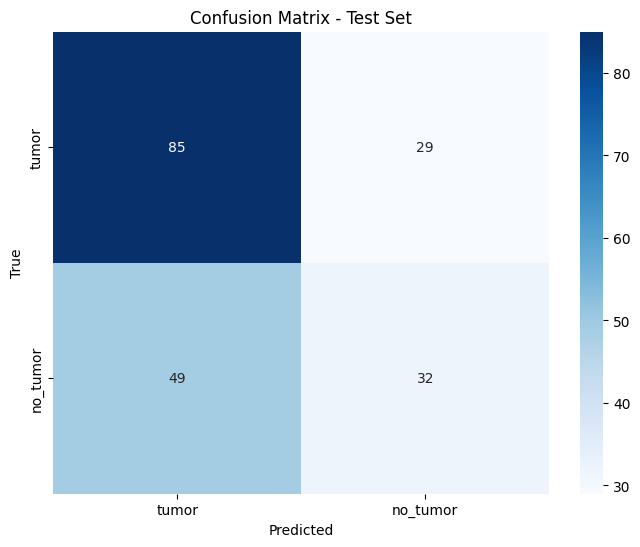

In [ ]:
# Function to load test images
def load_test_images(test_dir):
    test_image_paths = []
    test_labels = []
    for label, folder in enumerate(['tumor', 'no_tumor']):
        folder_path = os.path.join(test_dir, folder)
        for img_file in os.listdir(folder_path):
            test_image_paths.append(os.path.join(folder_path, img_file))
            test_labels.append(label)
    return test_image_paths, np.array(test_labels)

# Function to preprocess test images
def preprocess_test_image(image_path, img_size=(224, 224)):
    image = cv2.imread(image_path)
    if image is None:
        print(f"Failed to load image: {image_path}")
        return None
    image = cv2.resize(image, img_size)
    image = image / 255.0
    return image

# Load data
test_dir = '/content/drive/MyDrive/combined/test'  # Change this to your test image directory
test_image_paths, y_test_true = load_test_images(test_dir)

# Preprocess all test images
X_test = []
valid_test_image_paths = []

for img_path in test_image_paths:
    processed_image = preprocess_test_image(img_path)
    if processed_image is not None:
        X_test.append(processed_image)
        valid_test_image_paths.append(img_path)

X_test = np.array(X_test)

print(f"Number of valid test images: {len(X_test)}")
print(f"Number of test labels: {len(y_test_true)}")

assert len(X_test) == len(y_test_true), "The number of test images and test labels must match."

# Load the best model
best_model = load_model('best_resnet_model.h5')

# Predict on test data
y_test_pred = best_model.predict(X_test)
y_test_pred_classes = np.argmax(y_test_pred, axis=1)

# Classification report
print("Test Set Classification Report:")
print(classification_report(y_test_true, y_test_pred_classes, target_names=['tumor', 'no_tumor']))

# Confusion matrix
cm_test = confusion_matrix(y_test_true, y_test_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', xticklabels=['tumor', 'no_tumor'], yticklabels=['tumor', 'no_tumor'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Test Set')
plt.show()


The ResNet-50 model was tested on 195 images, yielding an overall accuracy of 60%. For the **tumor class**, it achieved a precision of 63%, recall of 75%, and an F1-score of 69%. For the **no tumor class**, the precision was 52%, recall was 40% and the F1-score was 45%. The macro average F1-score was 57%, indicating generally lower performance, particularly in identifying the "no tumor" class accurately.

### EfficientNetB0

Lastly, I'm going to train an EfficientNetB0 model with more epochs, using augmented images and balanced classes. EfficientNetB0, developed by Google, is known for its efficient computation and parameter usage. It uses compound scaling to improve performance by uniformly scaling depth, width, and resolution.

16705208/16705208 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 224, 224, 3)          0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 224, 224, 3)          7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 rescaling_1 (Rescaling)     

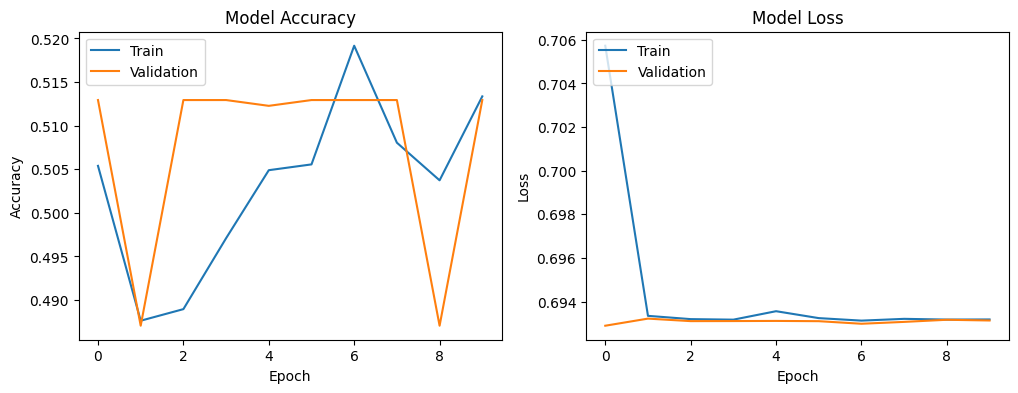

48/48 [==============================] - 26s 518ms/step
              precision    recall  f1-score   support

       tumor       0.51      1.00      0.68       773
    no_tumor       0.00      0.00      0.00       734

    accuracy                           0.51      1507
   macro avg       0.26      0.50      0.34      1507
weighted avg       0.26      0.51      0.35      1507

[[773   0]
 [734   0]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [12]:
# Function to load and preprocess images
def load_and_preprocess_images(image_dir, labels, img_size=(224, 224)):
    images = []
    processed_labels = []
    for label in labels:
        label_dir = os.path.join(image_dir, label)
        for image_file in os.listdir(label_dir):
            image_path = os.path.join(label_dir, image_file)
            image = cv2.imread(image_path)
            if image is not None:
                image = cv2.resize(image, img_size)
                images.append(image)
                processed_labels.append(labels[label])
    images = np.array(images) / 255.0
    processed_labels = to_categorical(np.array(processed_labels))
    return images, processed_labels

# Load images
image_dir = '/content/drive/MyDrive/combined/train'
labels = {'tumor': 0, 'no_tumor': 1, 'aug_no_tumor': 1}
images, processed_labels = load_and_preprocess_images(image_dir, labels)

# Convert processed_labels back to integer labels for class weight computation
integer_labels = np.argmax(processed_labels, axis=1)

# Split the data
X_train, X_val, y_train, y_val = train_test_split(images, processed_labels, test_size=0.2, random_state=42)

# Calculate class weights
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(integer_labels), y=integer_labels)
class_weights_dict = dict(enumerate(class_weights))

# Function to create and compile the CNN model
def create_efficientnet_model(input_shape, num_classes):
    base_model = EfficientNetB0(include_top=False, input_shape=input_shape, weights='imagenet')
    base_model.trainable = False  # Freeze the base model initially

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

# Model parameters
input_shape = (224, 224, 3)
num_classes = 2

# Create and summarize the model
model = create_efficientnet_model(input_shape, num_classes)
model.summary()

# Train the model with class weights
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), batch_size=32, class_weight=class_weights_dict)

# Plotting the training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

# Evaluate the model
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_val, axis=1)

print(classification_report(y_true, y_pred_classes, target_names=['tumor', 'no_tumor']))
conf_matrix = confusion_matrix(y_true, y_pred_classes)
print(conf_matrix)

The EfficientNetB0 model was trained over 10 epochs, showing an unsatisfactory performance in classifying between **tumor** and **no tumor** categories. It displayed a significant imbalance in its ability to identify classes correctly, achieving a precision of 0.51 for "tumor" but failing entirely on "no tumor" with a precision of 0.00. This resulted in a 100% recall for "tumor," meaning it identified all tumor cases but also incorrectly labeled all "no tumor" cases as tumors. Overall, the accuracy hovered around 50%, suggesting the model performed no better than random guessing and the training and validation losses showed no improvement, remaining consistent throughout the epochs.

## CNN with explainable AI

So far, CNN models have been the best-performing models. Therefore, we are going to use a CNN to understand how the model makes classification decisions. LimeImageExplainer, a tool from the LIME (Local Interpretable Model-agnostic Explanations) library, was used to explain the model's decisions. LIME helps interpret complex models by approximating them locally with simpler, interpretable models, thus providing insights into the features that influence the model's predictions.

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 26, 26, 128)       0

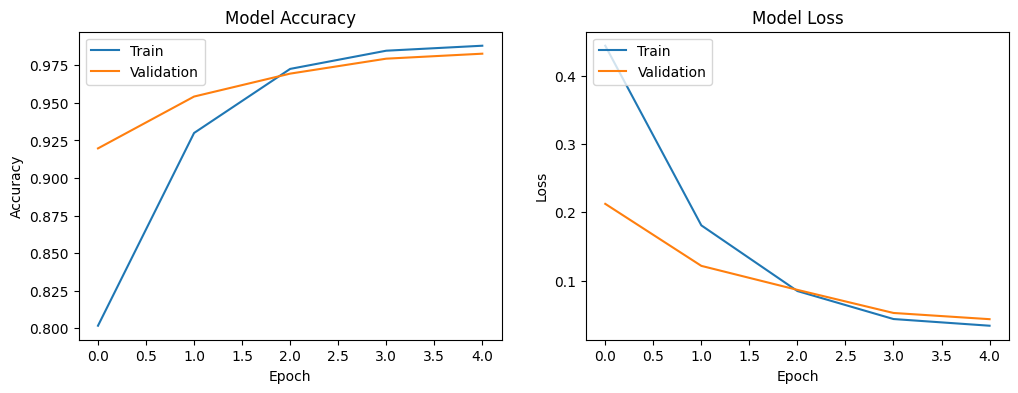

48/48 [==============================] - 8s 171ms/step
              precision    recall  f1-score   support

       tumor       0.99      0.98      0.98       773
    no_tumor       0.98      0.99      0.98       734

    accuracy                           0.98      1507
   macro avg       0.98      0.98      0.98      1507
weighted avg       0.98      0.98      0.98      1507



  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 75ms/step


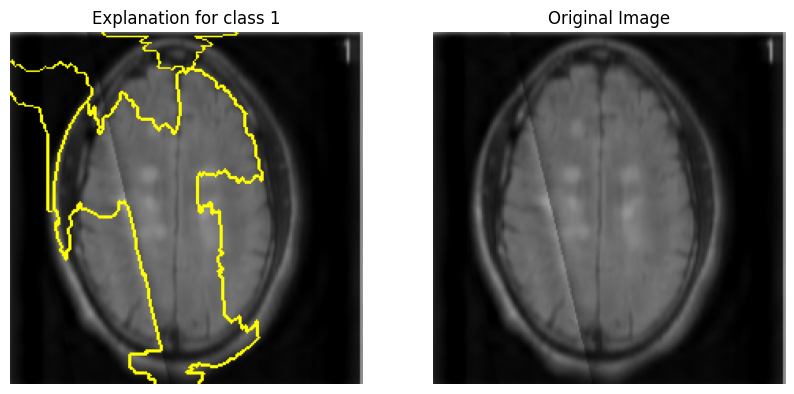

In [22]:
# Ensure clear session
tf.compat.v1.reset_default_graph()
tf.compat.v1.keras.backend.clear_session()

# Function to load and preprocess images
def load_and_preprocess_images(image_dir, labels, img_size=(224, 224)):
    images = []
    processed_labels = []
    for label in labels:
        label_dir = os.path.join(image_dir, label)
        for image_file in os.listdir(label_dir):
            image_path = os.path.join(label_dir, image_file)
            image = cv2.imread(image_path)
            if image is not None:
                image = cv2.resize(image, img_size)
                images.append(image)
                processed_labels.append(labels[label])
    images = np.array(images) / 255.0
    processed_labels = to_categorical(np.array(processed_labels))
    return images, processed_labels

# Load images
image_dir = '/content/drive/MyDrive/combined/train'
labels = {'tumor': 0, 'no_tumor': 1, 'aug_no_tumor': 1}
images, processed_labels = load_and_preprocess_images(image_dir, labels)

# Convert processed_labels back to integer labels for class weight computation
integer_labels = np.argmax(processed_labels, axis=1)

# Split the data
X_train, X_val, y_train, y_val = train_test_split(images, processed_labels, test_size=0.2, random_state=42)

# Calculate class weights
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(integer_labels), y=integer_labels)
class_weights_dict = dict(enumerate(class_weights))

# Function to create and compile the custom CNN model
def create_cnn_model(input_shape, num_classes):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Model parameters
input_shape = (224, 224, 3)
num_classes = 2

# Create and summarize the model
model = create_cnn_model(input_shape, num_classes)
model.summary()

# Train the model with class weights
history = model.fit(X_train, y_train, epochs=5, validation_data=(X_val, y_val), batch_size=32, class_weight=class_weights_dict)

# Plotting the training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

# Evaluate the model
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_val, axis=1)

print(classification_report(y_true, y_pred_classes, target_names=['tumor', 'no_tumor']))

# Initialize LIME Image Explainer
explainer = lime_image.LimeImageExplainer()

# Function to predict images for LIME
def model_predict(img_array, model):
    # Ensure the input is correctly shaped (batch, height, width, channels)
    if img_array.ndim == 3:
        img_array = np.expand_dims(img_array, axis=0)
    return model.predict(img_array)

# Select an image from validation set to explain
idx = 0
test_img = X_val[idx]

# Explain the prediction on the selected image
explanation = explainer.explain_instance(test_img.astype('float32'),
                                         classifier_fn=lambda x: model_predict(x, model),
                                         top_labels=2, hide_color=0, num_samples=1000)

# Get image and mask for the top class predicted
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)

# Display the explanation
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(mark_boundaries(test_img, mask))
ax1.set_title('Explanation for class {}'.format(explanation.top_labels[0]))
ax1.axis('off')

ax2.imshow(test_img)
ax2.set_title('Original Image')
ax2.axis('off')

plt.show()


The LIME explanation reveals that the model focused on specific areas of the brain scan (highlighted in yellow) to make its classification decision. It's interesting to see that the model was not only focused on the brain part but also on some seemingly random areas in the black background. This indicates that the model might be picking up on irrelevant features or noise, which suggests that further refinement and training may be necessary to improve its focus on the relevant parts of the image.

## Interpretation and Validation

The selection of the model architecture, such as CNN, ResNet-50 or EfficientNetB0, greatly influences performance. For instance, in this project the CNN models showed the best initial results, with higher accuracy compared to ResNet-50 and EfficientNetB0, which required more epochs and complex tuning. Data preprocessing steps, such as normalization, resizing and data augmentation are critical as they help in improving the model's ability to generalize. Augmented images in particular can address class imbalance and enhance the robustness of the model, as observed with the EfficientNetB0 model.

The number of epochs and the duration of training significantly affect the model’s performance. Longer training with more epochs can lead to better accuracy but it also risks overfitting. The experiments with EfficientNetB0, trained over multiple epochs, showed moderate performance improvement but required careful monitoring to avoid overfitting. Handling class imbalance through techniques like class weights or oversampling is essential. In this project, class weights helped in addressing imbalance, leading to better performance metrics, especially for the underrepresented classes.

Evaluating the model on a separate test set is crucial for understanding its real-world performance. The test with the ResNet-50 model revealed a lower accuracy compared to training, highlighting areas for further improvement. Tools like LIME are invaluable for interpreting model decisions. LIME explanations can show which parts of the input data the model focused on, helping us understand whether the model is making decisions based on relevant features or noise. In our case, LIME revealed that the CNN model sometimes focused on irrelevant areas, suggesting the need for further refinement.

Reflecting on these aspects allows us to make informed decisions about future steps. If the model's performance was suboptimal, we might consider fine-tuning hyperparameters, adjusting learning rates, batch sizes, or other parameters.